# Tutorial 1

**Credits**: Andrea Galassi, Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Data loading, Feature Extraction, Machine Learning, Text Classification, Sentiment Analysis

# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Federico Ruggeri -> federico.ruggeri6@unibo.it
* Eleonora Mancini -> e.mancini@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

## Important

**Make sure** to put all of us in cc when contacting us via mail!

## PART I ($\sim$25 mins)

*   How to **download** a dataset.
*   How to **inspect** a dataset.

## PART II ($\sim$25 mins)

* How to perform basic **text pre-processing** to identify input features.

## PART III ($\sim$25 mins)

*   How to **train a classifier** on identified input features for sentiment classification.
*   How to **evaluate** model performance and **inspect** its predictions.

## Task

We consider the task of **document classification**.

Specifically, we consider document **sentiment analysis** on movie reviews.

## Preliminaries

First of all, we need to import some useful packages that we will use during this hands-on session.

In [4]:
# file management
import sys
import shutil
import urllib
import tarfile
from pathlib import Path

# dataframe management
import pandas as pd

# data manipulation
import numpy as np

# for readability
from typing import Iterable

# viz
from tqdm import tqdm

In [5]:
# from notebook to live presentation format
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

{'width': 1024, 'height': 768, 'scroll': True}

# 1. Downloading the dataset

We download the IMDB movie reviews dataset.

In [6]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(download_path: Path, url: str):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=download_path, reporthook=t.update_to)


In [7]:
def download_dataset(download_path: Path, url: str):
    print("Downloading dataset...")
    download_url(url=url, download_path=download_path)
    print("Download complete!")

def extract_dataset(download_path: Path, extract_path: Path):
    print("Extracting dataset... (it may take a while...)")
    with tarfile.open(download_path) as loaded_tar:
        loaded_tar.extractall(extract_path)
    print("Extraction completed!")

In [8]:
url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset_name = "aclImdb"

print(f"Current work directory: {Path.cwd()}")
dataset_folder = Path.cwd().joinpath("Datasets")


Current work directory: /content


In [9]:
if not dataset_folder.exists():
    dataset_folder.mkdir(parents=True)

dataset_tar_path = dataset_folder.joinpath("Movies.tar.gz")
dataset_path = dataset_folder.joinpath(dataset_name)

if not dataset_tar_path.exists():
    download_dataset(dataset_tar_path, url)

if not dataset_path.exists():
    extract_dataset(dataset_tar_path, dataset_folder)

Let's have a look at the files we have downloaded to understand the dataset structure.

In [10]:
# an example from the dataset
file_path = dataset_folder.joinpath(dataset_name, 'train', 'pos', "0_9.txt")

# show the example
if file_path.is_file():
    # open the file
    with file_path.open(mode='r', encoding='utf-8') as text_file:
        text = text_file.read()
        print(text)

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!


## 1.1 Encode the dataset into a pandas.DataFrame

We encode the loaded dataset into a dataframe to better access to its content.

In [11]:
# list of dictionaries
dataframe_rows = []

for split in ['train', 'test']:
    for sentiment in ['pos', 'neg']:
        folder = dataset_folder.joinpath(dataset_name, split, sentiment)
        for file_path in folder.glob('*.txt'):
            with file_path.open(mode='r', encoding='utf-8') as text_file:
                text = text_file.read()
                score = file_path.stem.split("_")[1]
                score = int(score)
                file_id = file_path.stem.split("_")[0]

                num_sentiment = 1 if sentiment == 'pos' else 0

                dataframe_row = {
                    "file_id": file_id,
                    "score": score,
                    "sentiment": num_sentiment,
                    "split": split,
                    "text": text
                }

                dataframe_rows.append(dataframe_row)

In [12]:
folder = Path.cwd().joinpath("Datasets", "Dataframes", dataset_name)
if not folder.exists():
    folder.mkdir(parents=True)

# transform the list of rows in a proper dataframe
df = pd.DataFrame(dataframe_rows)
df = df[["file_id",
         "score",
         "sentiment",
         "split",
         "text"]
       ]
df_path = folder.with_name(dataset_name + ".pkl")
df.to_pickle(df_path)

## 1.2 Inspecting the dataset

We first have a look at the dataframe structure.

In [13]:
print("Dataframe structure:")
print(df)
print()

print("Total rows %d" % (len(df)))
print()

Dataframe structure:
      file_id  score  sentiment  split  \
0        5963     10          1  train   
1        3627      8          1  train   
2        2044      8          1  train   
3        5888      9          1  train   
4        7495      7          1  train   
...       ...    ...        ...    ...   
49995    5033      1          0   test   
49996    3188      1          0   test   
49997    1362      3          0   test   
49998    6850      2          0   test   
49999    5446      3          0   test   

                                                    text  
0      This movie is horrible, but you have to see it...  
1      What a fun movie experience! I was expecting a...  
2      This is good little shocker; not perfect by an...  
3      I was able to watch this movie in its entirety...  
4      Dwight Frye steals the show in this one as a f...  
...                                                  ...  
49995  I turned this off within the first five minute...  
49

In [14]:
print("Distribution of scores: ")
print(df['score'].value_counts())
print()

print("Distribution of sentiment: ")
print(df['sentiment'].value_counts())
print()

print("Distribution of splits: ")
print(df['split'].value_counts())
print()

Distribution of scores: 
score
1     10122
10     9731
8      5859
4      5331
3      4961
7      4803
9      4607
2      4586
Name: count, dtype: int64

Distribution of sentiment: 
sentiment
1    25000
0    25000
Name: count, dtype: int64

Distribution of splits: 
split
train    25000
test     25000
Name: count, dtype: int64



In [15]:
print("Distribution of sentiments in split: ")
print(df.groupby(['split','sentiment']).size())
print()

print("Distribution of scores in split: ")
print(df.groupby(['split','score']).size())
print()

print("Differences in score distribution in split: ")
print(df.groupby(['score','split',]).size())
print()

Distribution of sentiments in split: 
split  sentiment
test   0            12500
       1            12500
train  0            12500
       1            12500
dtype: int64

Distribution of scores in split: 
split  score
test   1        5022
       2        2302
       3        2541
       4        2635
       7        2307
       8        2850
       9        2344
       10       4999
train  1        5100
       2        2284
       3        2420
       4        2696
       7        2496
       8        3009
       9        2263
       10       4732
dtype: int64

Differences in score distribution in split: 
score  split
1      test     5022
       train    5100
2      test     2302
       train    2284
3      test     2541
       train    2420
4      test     2635
       train    2696
7      test     2307
       train    2496
8      test     2850
       train    3009
9      test     2344
       train    2263
10     test     4999
       train    4732
dtype: int64



In [16]:
print("Differences among score classes in the splits: ")
print(df.groupby(['sentiment','score','split']).size())
print()

Differences among score classes in the splits: 
sentiment  score  split
0          1      test     5022
                  train    5100
           2      test     2302
                  train    2284
           3      test     2541
                  train    2420
           4      test     2635
                  train    2696
1          7      test     2307
                  train    2496
           8      test     2850
                  train    3009
           9      test     2344
                  train    2263
           10     test     4999
                  train    4732
dtype: int64



### 1.2.1 Visualization

In [17]:
# Preliminaries
import matplotlib.pyplot as plt

We first visualize sentiment class distribution.

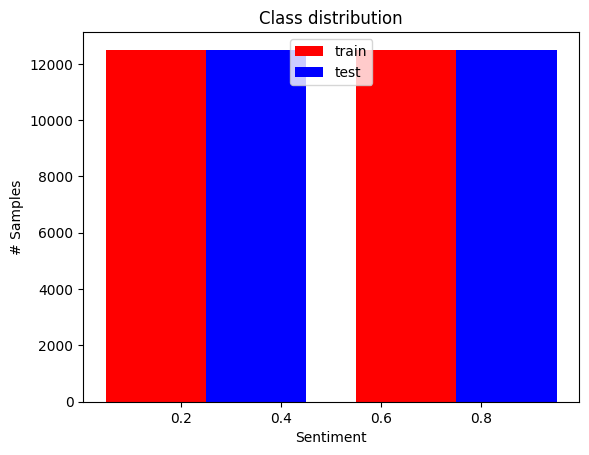

In [18]:
train_labels = df[df.split == 'train'].sentiment.values
test_labels = df[df.split == 'test'].sentiment.values

plt.hist([train_labels,test_labels], bins=2, label=['train','test'], color=["red", "blue"], align="mid")
plt.legend(loc='upper center')
plt.title('Class distribution')
plt.xlabel('Sentiment')
plt.ylabel('# Samples')
plt.show()

Then we visualize sentiment scores.

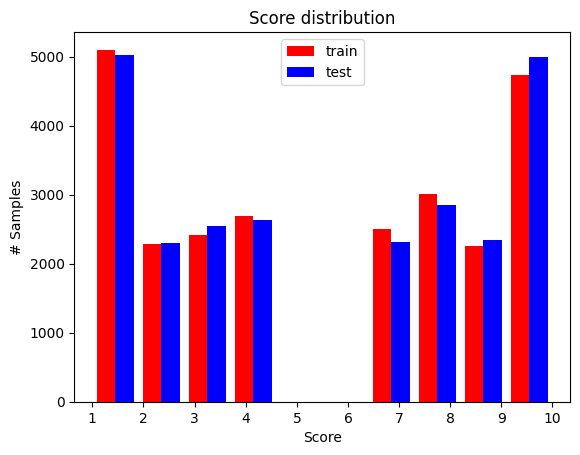

In [19]:
train_scores = df[df.split == 'train'].score.values
test_scores = df[df.split == 'test'].score.values

plt.xticks(range(1,11))
plt.hist([train_scores,test_scores], bins=10, label=['train','test'], color=["red", "blue"], align="mid")
plt.legend(loc='upper center')
plt.title('Score distribution')
plt.xlabel('Score')
plt.ylabel('# Samples')

plt.show()

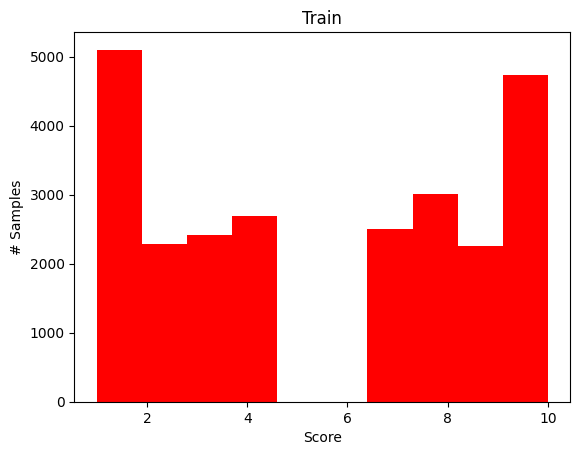

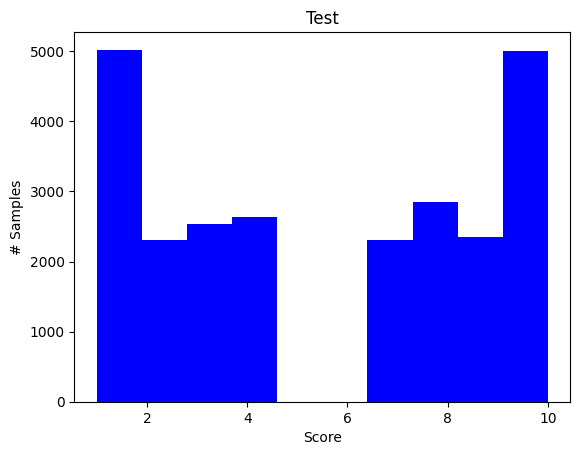

In [20]:
plot1 = plt.figure(1)
plt.hist(train_scores, 10, color="red")
plt.xlabel('Score')
plt.ylabel('# Samples')
plt.title("Train")

plot2 = plt.figure(2)
plt.hist(test_scores, 10, color="blue")
plt.xlabel('Score')
plt.ylabel('# Samples')
plt.title("Test")

plt.show()

Lastly, we check text length distribution.

In [21]:
import nltk
from nltk.tokenize import word_tokenize

# necessary for being able to tokenize
nltk.download('punkt_tab')
nltk.download('punkt')

train_texts = df[df.split == 'train'].text.values
test_texts = df[df.split == 'test'].text.values

train_lengths = [len(word_tokenize(text)) for text in tqdm(train_texts)]
test_lengths = [len(word_tokenize(text)) for text in tqdm(test_texts)]

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 25000/25000 [00:55<00:00, 452.81it/s]


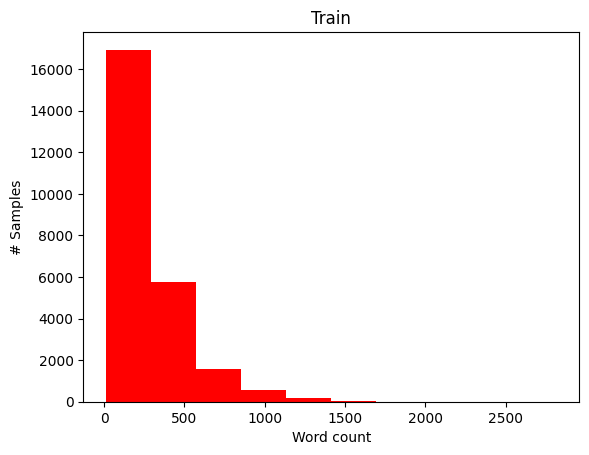

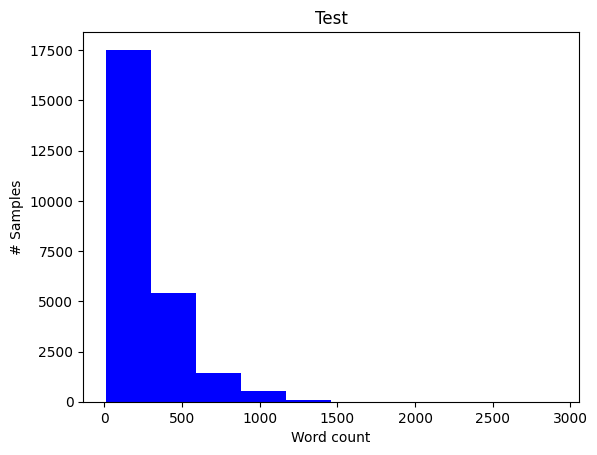

In [22]:
plot1 = plt.figure(1)
plt.hist(train_lengths, color="red")
plt.xlabel('Word count')
plt.ylabel('# Samples')
plt.title("Train")

plot2 = plt.figure(2)
plt.hist(test_lengths, 10, color="blue")
plt.xlabel('Word count')
plt.ylabel('# Samples')
plt.title("Test")

plt.show()



# This is formatted as code

## 2. Feature Extraction

We are now ready to address the sentiment analysis task.

We consider the sentiment classification task for description purposes.

We first **determine** the inputs and outputs of our classifier.

Then, we define **how to encode** the inputs and outputs for the classifier.

### Inputs and Outputs

<center>
    <img src="/content/drive/MyDrive/NLP/tutorial-1/images/inputs_outputs.png" alt="inputs and outputs" />
</center>

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Input features and Outputs

We will encode input text into a numerical format: **bag-of-words**.

<center>
    <img src="/content/drive/MyDrive/NLP/tutorial-1/images/inputs_outputs_features.png" alt="features and outputs" />
</center>

Sentiment score prediction has the same schema where the *output label* is replaced by the sentiment score.

### 2.1 Bag-of-Words Encoding

The [scikit-learn](https://scikit-learn.org/stable/) library offers *TfidfVectorizer*, a class that performs both tokenization and the creation of the Bag-of-Words (BoW) representation of a corpus.

In particular, it computes tf-idf representation for each word token.

#### Homework 📖

The class has plenty of options: it can be used also to count n-grams, excluding stop-words, and cutting off most and/or less frequent terms.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

# select only the training sentences
df_train = df.loc[df['split'] == "train"]

# extract the texts
train_texts = df_train.text.values

# Using n-grams (unigrams + bigrams), removing English stop-words, and filtering out rare/common terms
vectorizer_advanced = TfidfVectorizer(
    ngram_range=(1, 2),        # Unigrams and bigrams
    stop_words='english',      # Exclude common English stop-words
    max_df=0.9,                # Exclude terms in more than 90% of documents
    min_df=5                   # Exclude terms in fewer than 5 documents
)

# Re-fit on the same text to compare with previous results
X_train_advanced = vectorizer_advanced.fit_transform(train_texts)
print("\nShape with advanced vectorizer settings (data points, features):")
print(X_train_advanced.shape)



Shape with advanced vectorizer settings (data points, features):
(25000, 81097)


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

# select only the training sentences
df_train = df.loc[df['split'] == "train"]

# extract the texts
train_texts = df_train.text.values

print("Processing corpus\n")
vectorizer = TfidfVectorizer()

# tokenization and creation of Bag of Words representation
X_train = vectorizer.fit_transform(train_texts)

print("Shape of the matrix: (data points, features)")
print(X_train.shape)
print()

# targets for the training set
Y_train = df_train.sentiment.values

Processing corpus

Shape of the matrix: (data points, features)
(25000, 74849)



The vectorizer **fits** on the provided texts to create an internal vocabulary.

The vocabulary is used to create the BoW representation.

The vocabulary is a dictionary that associates to each word a corresponding column in the feature matrix.

#### Homework 📖

Do not try to print the whole vocabulary: it is quite large ;)

Still, **it is very important** to have a look at detected tokens!

In [26]:
# Retrieve the list of tokens (features) created by TfidfVectorizer
tokens = vectorizer.get_feature_names_out()

# Display the first few tokens to inspect
print("First 10 tokens created by TfidfVectorizer:")
print(tokens[:10])
print()

# Alternatively, to see all tokens
print("All tokens created by TfidfVectorizer:")
print(tokens)

First 10 tokens created by TfidfVectorizer:
['00' '000' '0000000000001' '00001' '00015' '000s' '001' '003830' '006'
 '007']

All tokens created by TfidfVectorizer:
['00' '000' '0000000000001' ... 'østbye' 'über' 'üvegtigris']


Let's check the size of the built vocabulary.

In [27]:
print("Size of vocabulary:")
print(len(vectorizer.vocabulary_))
print(type(vectorizer.vocabulary_))

Size of vocabulary:
74849
<class 'dict'>


Since the vocabulary is quite big, the BoW representation of input texts is a *sparse* matrix (see [scipy.sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html) for more info).

Simply put, a sparse matrix is represented as a dictionary of non-zero entries, where the keys are the matrix coordinates.

In [28]:
# show the sparse matrix representation
print(X_train)

  (0, 66562)	0.06955964340028999
  (0, 44147)	0.023577034244514922
  (0, 34585)	0.07015782874771444
  (0, 31669)	0.06668241553847637
  (0, 9881)	0.0631023814962809
  (0, 74324)	0.02541564903851585
  (0, 30118)	0.024785428026357102
  (0, 67125)	0.0672650073589832
  (0, 58585)	0.03365503694854996
  (0, 34683)	0.03527989180688014
  (0, 6459)	0.037750592546869355
  (0, 46680)	0.04994199973914968
  (0, 66322)	0.03819128293331987
  (0, 46050)	0.04793015265247475
  (0, 30670)	0.043421250804217625
  (0, 18790)	0.10333273746694768
  (0, 66339)	0.17547293347619508
  (0, 22081)	0.06268024213483626
  (0, 24536)	0.025057640448278927
  (0, 35787)	0.029462866876408738
  (0, 28547)	0.07334324335240233
  (0, 11719)	0.08335433561489178
  (0, 57873)	0.09101794882084631
  (0, 22737)	0.12575795749989058
  (0, 72753)	0.06384922973254444
  :	:
  (24999, 55536)	0.09617630563726272
  (24999, 60326)	0.07599253647852348
  (24999, 70881)	0.14368021791659608
  (24999, 51707)	0.12301638514991961
  (24999, 55530)	0.

It is possible to get the dense representation of a feature matrix.

**Keep in mind** that the matrix will occupy a lot of memory.

In [29]:
# show the full matrix --> lots of memory to be stored
print(X_train.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### Homework 📖

Try taking a subset of the matrix and inspect its dense representation.

In [33]:
# Define the interval for rows and columns
row_start = 10  # Start of row interval
row_end = 20    # End of row interval
col_start = 100  # Start of column interval
col_end = 200    # End of column interval

# Slice the sparse matrix for the specified range of rows and columns
subset = X_train[row_start:row_end, col_start:col_end]

# Convert the sliced sparse matrix to dense to inspect it
subset_dense = subset.toarray()

# Print the dense representation of the selected subset
print(f"Dense representation of rows {row_start}-{row_end-1} and columns {col_start}-{col_end-1}:")
print(subset_dense)

# Optionally, you can print out the non-zero elements (if you're interested in them specifically)
# Iterate over rows in the selected subset
for row_index in range(row_start, row_end):
    row = X_train.getrow(row_index)
    print(f"Non-zero elements in row {row_index}:")
    # Only print the non-zero elements within the specified columns
    for col, val in zip(row.indices, row.data):
        if col_start <= col < col_end:
            print(f"    Column {col}: {val}")


Dense representation of rows 10-19 and columns 100-199:
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.1302614  0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.       

We use our fitted Vectorizer to transform test texts as well.

**Make sure** you invoke ``vectorizer.transform()`` and **not** ``vectorizer.fit_transform()``.

In [34]:
# select only the test sentences
df_test = df.loc[df['split'] == "test"]
test_texts = df_test.text.values

# apply the vectorization to the test set
X_test = vectorizer.transform(test_texts)
Y_test = df_test.sentiment.values

**GOLDEN RULE: DO NOT EVER EVER EVER EVER MESS WITH THE TEST SET!!!!**

You **should never** add or remove rows/instances/data points from the test set.

You **should never** alter the ground-truth labels.

You **can** process it to transform, add, or remove columns/features.

You **can** modify the train set more freely.


But **keep your gross fingerprints** from the test set: it is untouchable, whatever its quality.

<br/>

<center>
    <img src="https://media.tenor.com/rPtHkeV2tkYAAAAC/stay-away-coronavirus.gif" alt="features and outputs" />
</center>

So far, we have encoded the text as it is.

We can perform additional pre-processing to 'normalize' the provided text.

### 2.2 Stemming

*''Stemming usually refers to a crude heuristic process that **chops off** the ends of words to reduce words to a common form.''*

<div align='right'>
(Introduction to Information Retrieval ~ C. D. Manning)
</div>

**Example**

*programmer*, *programs*, *programming* $\rightarrow$ *program*

In [35]:
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize, WhitespaceTokenizer

stemmer = SnowballStemmer("english")
tokenizer = WhitespaceTokenizer()

In [36]:
def stem_text(text: str):
    words = [stemmer.stem(word) for word in tokenizer.tokenize(text)]
    return " ".join(words)

st_train_texts = [stem_text(text) for text in tqdm(train_texts)]  # stemming over training
st_test_texts = [stem_text(text) for text in tqdm(test_texts)]    # stemming over testing

100%|██████████| 25000/25000 [01:26<00:00, 289.49it/s]


In [37]:
print(train_texts[0][:100])
print()
print(st_train_texts[0][:100])

This movie is horrible, but you have to see it because of that. I'm not here to discuss the entire f

this movi is horrible, but you have to see it becaus of that. i'm not here to discuss the entir film


We encoded the pre-processed texts as before via the ``TfidfVectorizer``.

In [38]:
print("Processing corpus\n")
st_vectorizer =  TfidfVectorizer()
st_X_train = st_vectorizer.fit_transform(st_train_texts)
st_X_test = st_vectorizer.transform(st_test_texts)

print("Shape of the matrix: (data points, features)")
print(st_X_train.shape)
print()

Processing corpus

Shape of the matrix: (data points, features)
(25000, 70363)



### 2.3 Lemmatization

*''Lemmatization usually refers to use a vocabulary and morphological analysis of words to return the base or dictionary form of a word, known as **lemma**''*

<div align='right'>
(Introduction to Information Retrieval ~ C. D. Manning)
</div>

**Example**

*saw*, *seen*, *sees* $\rightarrow$ *see*

In [39]:
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [40]:
def get_wordnet_key(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

def lem_text(text: str):
    tokens = tokenizer.tokenize(text)                                                   # tokenize
    tagged = pos_tag(tokens)                                                            # tag
    words = [lemmatizer.lemmatize(word, get_wordnet_key(tag)) for word, tag in tagged]  # lemmatize
    return " ".join(words)

lem_train_texts = [lem_text(text) for text in tqdm(train_texts, leave=True, position=0)]
lem_test_texts = [lem_text(text) for text in tqdm(test_texts, leave=True, position=0)]

100%|██████████| 25000/25000 [06:33<00:00, 63.54it/s]


In [41]:
print(train_texts[40][:100])
print()
print(lem_train_texts[40][:100])

As did others in this forum, when "Fobidden Planet" was offered in 1956, I rushed to see it. This st

As do others in this forum, when "Fobidden Planet" be offer in 1956, I rush to see it. This story be


We encoded the pre-processed texts as before via the ``TfidfVectorizer``.

In [42]:
print("Processing corpus\n")
lem_vectorizer =  TfidfVectorizer()
lem_X_train = lem_vectorizer.fit_transform(lem_train_texts)
lem_X_test = lem_vectorizer.transform(lem_test_texts)

print("Shape of the matrix: (data points, features)")
print(lem_X_train.shape)
print()

Processing corpus

Shape of the matrix: (data points, features)
(25000, 70643)



## 3. Training and Evaluating a Classifier

We are now ready to try out some standard machine learning classifiers.

**But** first, we introduce some baselines.

#### The importance of defining good baselines

Good baselines are always needed to consistently evaluate employed models.

When proposing a novel model, good baselines are recent state-of-the-art models.

When proposing a benchmark, good baselines are general-purpose off-the-shelf models.

### 3.1 Baselines

The majority baseline always predicts the majority class.

The random baseline makes uniform random predictions.

Their performances will tell us how much difficult this task is.

In [43]:
from sklearn.dummy import DummyClassifier

majority_classifier = DummyClassifier(strategy="prior")  # predicts always the bigger class
uniform_classifier = DummyClassifier(strategy="uniform") # random (unifirm) calss prediction

majority_classifier.fit(X_train, Y_train)
uniform_classifier.fit(X_train, Y_train)

# we don't need ot train those models, them are fixed
Y_pred_train_maj = majority_classifier.predict(X_train)
Y_pred_test_maj = majority_classifier.predict(X_test)
Y_pred_train_uni = uniform_classifier.predict(X_train)
Y_pred_test_uni = uniform_classifier.predict(X_test)

#### Homework 📖

Try out a random baseline that samples predictions according to label distribution.

In [44]:
from sklearn.dummy import DummyClassifier

# Create a stratified random baseline classifier
stratified_classifier = DummyClassifier(strategy="stratified")

# Train the classifier with the training data
stratified_classifier.fit(X_train, Y_train)

# Make predictions on the training and test sets
Y_pred_train_stratified = stratified_classifier.predict(X_train)  # Stratified predictions on training set
Y_pred_test_stratified = stratified_classifier.predict(X_test)    # Stratified predictions on test set

# Optionally: print or inspect the predictions
print("Predictions (Train) with Stratified Baseline:", Y_pred_train_stratified)
print("Predictions (Test) with Stratified Baseline:", Y_pred_test_stratified)


Predictions (Train) with Stratified Baseline: [0 1 1 ... 0 1 1]
Predictions (Test) with Stratified Baseline: [0 1 0 ... 1 1 1]


We now evaluate model predictions via some metrics.

In [45]:
from sklearn.metrics import classification_report

def evaluate_classification(y_true, y_pred):
    report = classification_report(y_true, y_pred, target_names=['neg', 'pos'])
    print(report)

In [47]:
print("majority on training")
evaluate_classification(y_true=Y_train, y_pred=Y_pred_train_maj)
print()
print("majority on testing")
evaluate_classification(y_true=Y_test, y_pred=Y_pred_test_maj)
print()

majority on training
              precision    recall  f1-score   support

         neg       0.50      1.00      0.67     12500
         pos       0.00      0.00      0.00     12500

    accuracy                           0.50     25000
   macro avg       0.25      0.50      0.33     25000
weighted avg       0.25      0.50      0.33     25000


majority on testing
              precision    recall  f1-score   support

         neg       0.50      1.00      0.67     12500
         pos       0.00      0.00      0.00     12500

    accuracy                           0.50     25000
   macro avg       0.25      0.50      0.33     25000
weighted avg       0.25      0.50      0.33     25000




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [48]:
print("uniform on training")
evaluate_classification(y_true=Y_train, y_pred=Y_pred_train_uni)
print()
print("uniform on testing")
evaluate_classification(y_true=Y_test, y_pred=Y_pred_test_uni)
print()

uniform on training
              precision    recall  f1-score   support

         neg       0.50      0.50      0.50     12500
         pos       0.50      0.49      0.50     12500

    accuracy                           0.50     25000
   macro avg       0.50      0.50      0.50     25000
weighted avg       0.50      0.50      0.50     25000


uniform on testing
              precision    recall  f1-score   support

         neg       0.50      0.50      0.50     12500
         pos       0.50      0.50      0.50     12500

    accuracy                           0.50     25000
   macro avg       0.50      0.50      0.50     25000
weighted avg       0.50      0.50      0.50     25000




In [51]:
print("stratified on training")
evaluate_classification(y_true=Y_train, y_pred=Y_pred_train_stratified)
print()
print("stratified on testing")
evaluate_classification(y_true=Y_test, y_pred=Y_pred_test_stratified)
print()

stratified on training
              precision    recall  f1-score   support

         neg       0.50      0.50      0.50     12500
         pos       0.50      0.51      0.51     12500

    accuracy                           0.50     25000
   macro avg       0.50      0.50      0.50     25000
weighted avg       0.50      0.50      0.50     25000


stratified on testing
              precision    recall  f1-score   support

         neg       0.50      0.51      0.50     12500
         pos       0.50      0.49      0.50     12500

    accuracy                           0.50     25000
   macro avg       0.50      0.50      0.50     25000
weighted avg       0.50      0.50      0.50     25000




#### 3.1.1 The importance of model evaluation

In most cases, accuracy is **not a very informative metric**.

Precision, recall, and F1 are more informative

F1 is generally a good indicator. In particular, macro F1 in case the test set in unbalanced.

Whether precision or recall are more important depends on the specific application, if the priority is to avoid false positives or false negatives.

Other metrics do exists (e.g., Area Under ROC Curve), always check the literature to find the most informative way to measure something!

#### Homework 📖

Try sampling an unbalanced test set and run model evaluation.

Do you see any differences in terms of metric values?

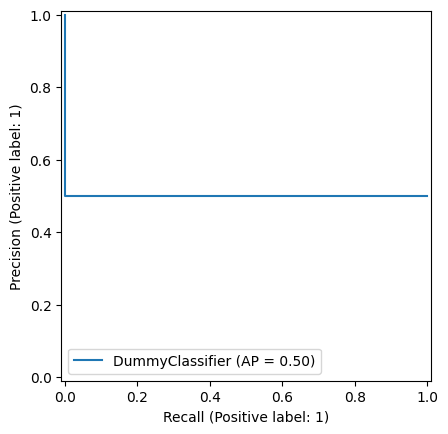

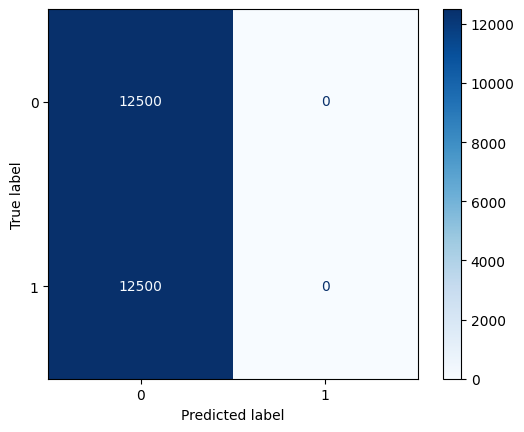

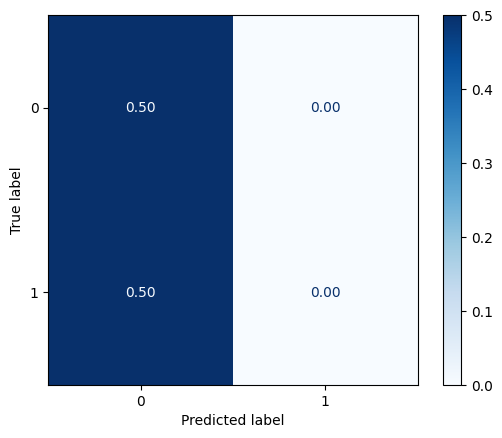

In [52]:
# plot precision/recall curve and confusion matrix
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, ConfusionMatrixDisplay, PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(majority_classifier, X_test, Y_test)
ConfusionMatrixDisplay.from_estimator(majority_classifier, X_test, Y_test, normalize=None, cmap=plt.cm.Blues)
ConfusionMatrixDisplay.from_estimator(majority_classifier, X_test, Y_test, normalize='all', cmap=plt.cm.Blues, values_format=".2f")

In most cases it is better to use the normalized version, especially with unbalanced distributions!

Looking at confusion tables row-wise gives information about recall, looking column-wise gives information about precision.

<center>
    <img src="images/confusion_matrix.png" alt="confusion matrix" />
</center>

<div align='right'>
(wikipedia)
</div>

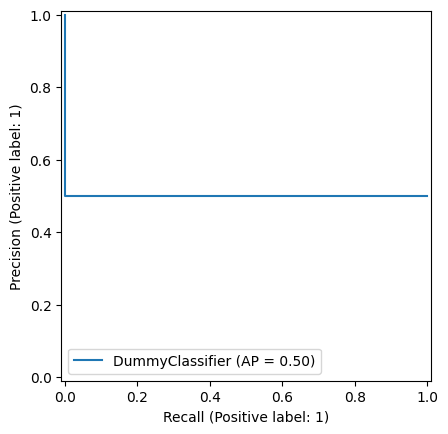

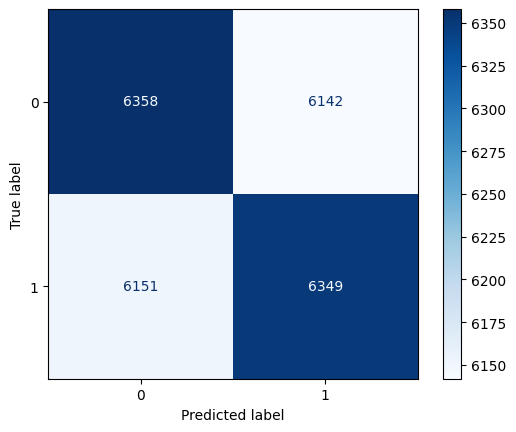

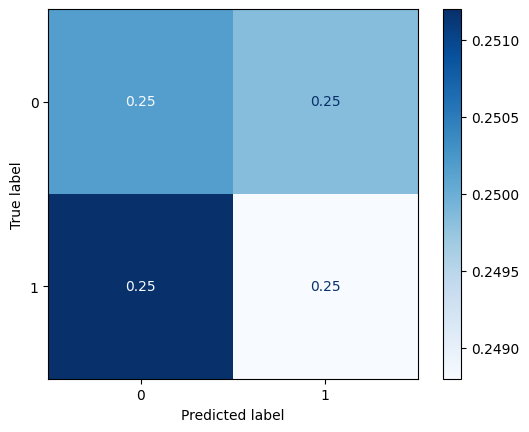

In [53]:
PrecisionRecallDisplay.from_estimator(uniform_classifier, X_test, Y_test)
ConfusionMatrixDisplay.from_estimator(uniform_classifier, X_test, Y_test, normalize=None, cmap=plt.cm.Blues)
ConfusionMatrixDisplay.from_estimator(uniform_classifier, X_test, Y_test, normalize='all', cmap=plt.cm.Blues, values_format=".2f")

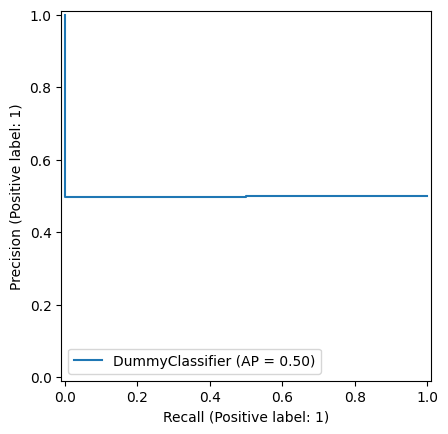

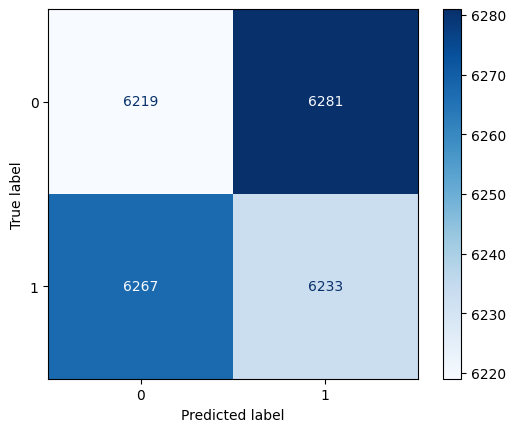

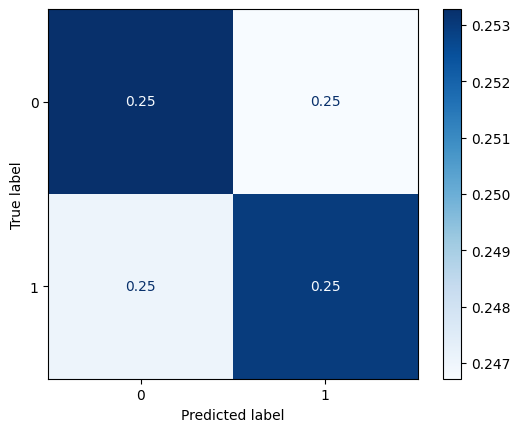

In [54]:
PrecisionRecallDisplay.from_estimator(stratified_classifier, X_test, Y_test)
ConfusionMatrixDisplay.from_estimator(stratified_classifier, X_test, Y_test, normalize=None, cmap=plt.cm.Blues)
ConfusionMatrixDisplay.from_estimator(stratified_classifier, X_test, Y_test, normalize='all', cmap=plt.cm.Blues, values_format=".2f")

### 3.2 Bayes Classifier

Let's try out our first classifier: A Naive Bayes Classifier (NB).

In [56]:
from sklearn.naive_bayes import MultinomialNB

# load the model
nb_classifier = MultinomialNB()

# train the model
nb_classifier.fit(X_train, Y_train)

# predict train set
Y_pred_train_nb = nb_classifier.predict(X_train)

#predict test set
Y_pred_test_nb = nb_classifier.predict(X_test)

In [57]:
# evaluate classification over train and test set
evaluate_classification(y_true=Y_train, y_pred=Y_pred_train_nb)
evaluate_classification(y_true=Y_test, y_pred=Y_pred_test_nb)

              precision    recall  f1-score   support

         neg       0.89      0.93      0.91     12500
         pos       0.93      0.89      0.91     12500

    accuracy                           0.91     25000
   macro avg       0.91      0.91      0.91     25000
weighted avg       0.91      0.91      0.91     25000

              precision    recall  f1-score   support

         neg       0.79      0.89      0.84     12500
         pos       0.87      0.77      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



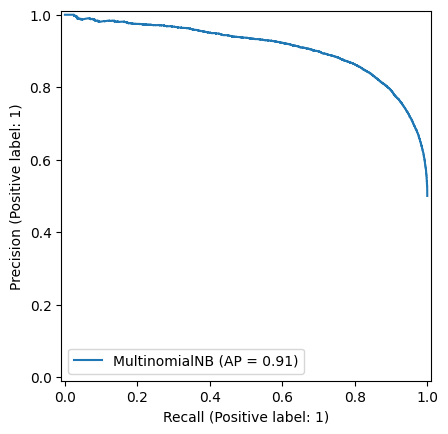

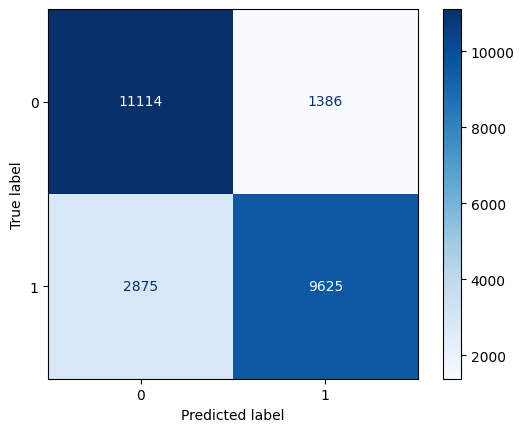

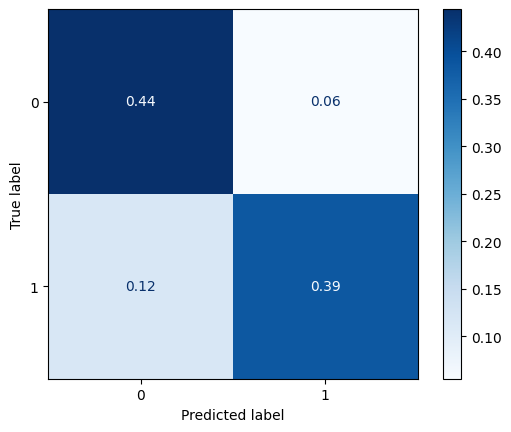

In [58]:
PrecisionRecallDisplay.from_estimator(nb_classifier, X_test, Y_test)
ConfusionMatrixDisplay.from_estimator(nb_classifier, X_test, Y_test, cmap=plt.cm.Blues)
ConfusionMatrixDisplay.from_estimator(nb_classifier, X_test, Y_test, normalize='all', cmap=plt.cm.Blues, values_format=".2f")

### 3.3 SVC Classifier

We consider another classifier: a Support Vector Machine (SVM).

In [59]:
from sklearn.svm import LinearSVC

# load the model
svc_classifier = LinearSVC()

# train the model
svc_classifier.fit(X_train, Y_train)

# make prediction
Y_pred_train_svc = svc_classifier.predict(X_train)
Y_pred_test_svc = svc_classifier.predict(X_test)

In [60]:
evaluate_classification(y_true=Y_train, y_pred=Y_pred_train_svc)
evaluate_classification(y_true=Y_test, y_pred=Y_pred_test_svc)

              precision    recall  f1-score   support

         neg       0.99      0.99      0.99     12500
         pos       0.99      0.99      0.99     12500

    accuracy                           0.99     25000
   macro avg       0.99      0.99      0.99     25000
weighted avg       0.99      0.99      0.99     25000

              precision    recall  f1-score   support

         neg       0.87      0.89      0.88     12500
         pos       0.89      0.87      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



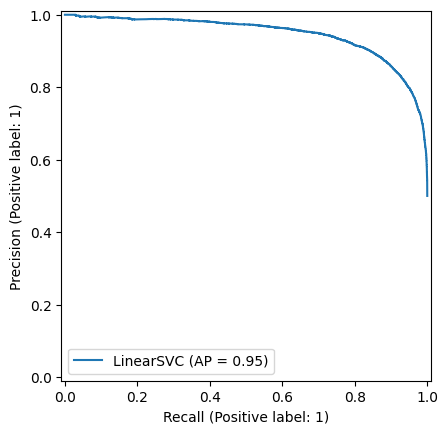

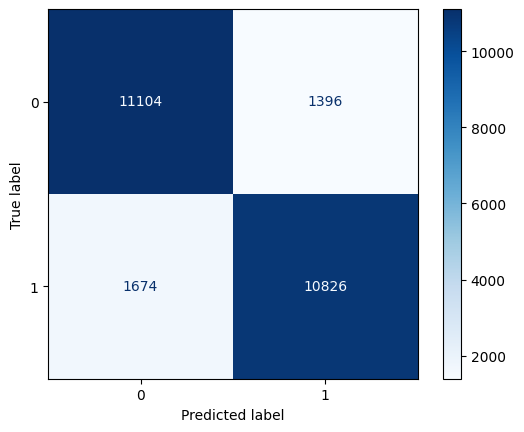

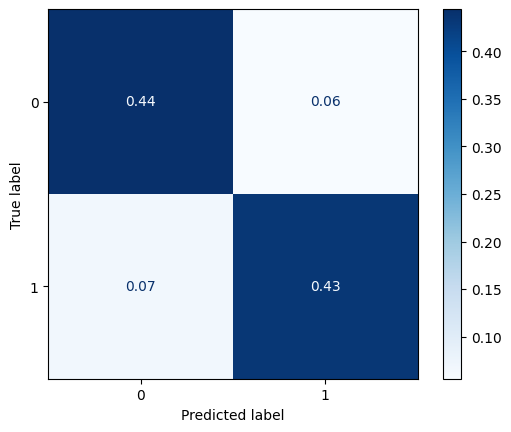

In [61]:
PrecisionRecallDisplay.from_estimator(svc_classifier, X_test, Y_test)
ConfusionMatrixDisplay.from_estimator(svc_classifier, X_test, Y_test, cmap=plt.cm.Blues)
ConfusionMatrixDisplay.from_estimator(svc_classifier, X_test, Y_test, normalize='all', cmap=plt.cm.Blues, values_format=".2f")

### 3.4 Error Analysis

Let's try to understand what kind of errors are done by the model.

We can look at specific cases of error.

In [62]:
# confidence of the model
confidence = svc_classifier.decision_function(X_test)

fp_i = []
fn_i = []
fp_v = []
fn_v = []
fp_c = []
fn_c = []

for index, value in enumerate(Y_test):
    # false positives
    if value==0 and Y_pred_test_svc[index]==1:
        fp_i.append(index)
        fp_v.append(value)
        fp_c.append(confidence[index])
    # false negatives
    elif value==1 and Y_pred_test_svc[index]==0:
        fn_i.append(index)
        fn_v.append(value)
        fn_c.append(confidence[index])

Let's print some examples of FN and FP and the confidence in their classification

In [63]:
print("FN")

for index in [0, 3]:
    print(test_texts[fn_i[index]])
    print(fn_c[index])
    print()

FN
The "old dark house" sub-genre that dominated the early talkies rarely fails to disappoint when we re-view the oldies to-day. Here is one that provides so very many suspicious characters you have to wonder how they will be able to tie up all the loose ends in the 6 reel running time.<br /><br />The Crooked Circle is a gang of counterfeiters and thieves who have decided to take revenge on Col. Walters (Berton Churchill) who has sent one of their ranks to prison. They decide he must die that very night. Meanwhile the Colonel's own group, The Sphinx Club, is determined to protect him at all costs. This does not sit well with Thelma (Irene Purcell) fiancée of club member Brand Osborne (Ben Lyon, late of the mega-budgeted HELL'S ANGELS (1930)) who wants him to quit the club and stop endangering his own life. Brand promises to resign after saving the colonel's life. Everyone heads off to Walters newly purchased mansion on Long Island to await the assassin.<br /><br />The Colonel might be 

In [64]:
print("FP")

for index in [0, 6]:
    print(test_texts[fp_i[index]])
    print(fp_c[index])
    print()

FP
Some may go for a film like this but I most assuredly did not. A college professor, David Norwell, suddenly gets a yen for adoption. He pretty much takes the first child offered, a bad choice named Adam. As it turns out Adam doesn't have both oars in the water which, almost immediately, causes untold stress and turmoil for Dr. Norwell. This sob story drolly played out with one problem after another, all centered around Adam's inabilities and seizures. Why Norwell wanted to complicate his life with an unknown factor like an adoptive child was never explained. Along the way the good doctor managed to attract a wifey to share in all the hell the little one was dishing out. Personally, I think both of them were one beer short of a sixpack. Bypass this yawner.
0.004359987078401392

"Shadows and Fog" is surely one of Woody Allen's weakest films, right up there with "September" and "Hollywood Ending" (though nothing Allen has done equals the awfulness of "Anything Else").<br /><br />"Shado

We now check the sentences for which the classification error is bigger.

In [66]:
# select the FP with the highest confidence
max_fp = fp_c.index(max(fp_c))
print(test_texts[fp_i[max_fp]])
print(fp_c[max_fp])

print()

# for false negatives the confidence is negative
max_fn = fn_c.index(min(fn_c))
print(test_texts[fp_i[max_fn]])
print(fn_c[max_fn])

This movie was pure genius. John Waters is brilliant. It is hilarious and I am not sick of it even after seeing it about 20 times since I bought it a few months ago. The acting is great, although Ricki Lake could have been better. And Johnny Depp is magnificent. He is such a beautiful man and a very talented actor. And seeing most of Johnny's movies, this is probably my favorite. I give it 9.5/10. Rent it today!
2.070318043538712

I remember viewing this movie when I was a kid. I recall it terrified me immensely and it stayed with me all these years. I spent a couple of years trying to find it online...didn't remember the title, only the storyline. After searching and searching, I came across a VHS that was being sold on E-Bay. I was excited and when it finally arrived, I jammed it into the VCR and couldn't help but feel a bit nostalgic. Needless to say, I was slightly disappointed. This wasn't the movie I remember watching as a kid. It was boring at times and I found Beryl Reid's ince

Let's now consider the stemmed and lemmatized versions of our input features.

In [67]:
# load the model
svc_classifier_st = LinearSVC()

# train the model
svc_classifier_st.fit(st_X_train, Y_train)

# make predictions
Y_pred_train_svc_st = svc_classifier_st.predict(st_X_train)
Y_pred_test_svc_st = svc_classifier_st.predict(st_X_test)

In [68]:
evaluate_classification(y_true=Y_train, y_pred=Y_pred_train_svc_st)
evaluate_classification(y_true=Y_test, y_pred=Y_pred_test_svc_st)

              precision    recall  f1-score   support

         neg       0.99      0.99      0.99     12500
         pos       0.99      0.99      0.99     12500

    accuracy                           0.99     25000
   macro avg       0.99      0.99      0.99     25000
weighted avg       0.99      0.99      0.99     25000

              precision    recall  f1-score   support

         neg       0.87      0.88      0.87     12500
         pos       0.88      0.86      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



In [70]:
# load the model
svc_classifier_lem = LinearSVC()

# train the model
svc_classifier_lem.fit(lem_X_train, Y_train)

# make predictions
Y_pred_train_svc_lem = svc_classifier_lem.predict(lem_X_train)
Y_pred_test_svc_lem = svc_classifier_lem.predict(lem_X_test)

In [71]:
evaluate_classification(y_true=Y_train, y_pred=Y_pred_train_svc_lem)
evaluate_classification(y_true=Y_test, y_pred=Y_pred_test_svc_lem)

              precision    recall  f1-score   support

         neg       0.99      0.99      0.99     12500
         pos       0.99      0.99      0.99     12500

    accuracy                           0.99     25000
   macro avg       0.99      0.99      0.99     25000
weighted avg       0.99      0.99      0.99     25000

              precision    recall  f1-score   support

         neg       0.86      0.88      0.87     12500
         pos       0.88      0.86      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



### 3.4.1 Comparisons

Let's organize our results in a Table to better compare models.

| Model       | F1-macro |
| ---         | ---      |
| Random      | .50      |
| Majority    | .33      |
| NB          |  .83     |
| SVM         | **.88**      |
| SVM w/ Stem | .87      |
| SVM w/ Lem  | .87      |

#### Homework

Try out the NB classifier with Stemmed and Lemmatized input features, respectively.

What do you observe?

In [72]:
# load the model
nb_classifier_st = MultinomialNB()

# train the model
nb_classifier_st.fit(st_X_train, Y_train)

# make predictions
Y_pred_train_nb_st = nb_classifier_st.predict(st_X_train)
Y_pred_test_nb_st = nb_classifier_st.predict(st_X_test)

In [73]:
# evaluate the model
evaluate_classification(y_true=Y_train, y_pred=Y_pred_train_nb_st)
evaluate_classification(y_true=Y_test, y_pred=Y_pred_test_nb_st)

              precision    recall  f1-score   support

         neg       0.89      0.93      0.91     12500
         pos       0.92      0.89      0.90     12500

    accuracy                           0.91     25000
   macro avg       0.91      0.91      0.91     25000
weighted avg       0.91      0.91      0.91     25000

              precision    recall  f1-score   support

         neg       0.79      0.88      0.83     12500
         pos       0.87      0.76      0.81     12500

    accuracy                           0.82     25000
   macro avg       0.83      0.82      0.82     25000
weighted avg       0.83      0.82      0.82     25000



In [74]:
# load the model
nb_classifier_lem = MultinomialNB()

# train the model
nb_classifier_lem.fit(lem_X_train, Y_train)

# make predictions
Y_pred_train_nb_lem = nb_classifier_lem.predict(lem_X_train)
Y_pred_test_nb_lem = nb_classifier_lem.predict(lem_X_test)

In [75]:
# evaluate the model
evaluate_classification(y_true=Y_train, y_pred=Y_pred_train_nb_lem)
evaluate_classification(y_true=Y_test, y_pred=Y_pred_test_nb_lem)

              precision    recall  f1-score   support

         neg       0.89      0.93      0.91     12500
         pos       0.92      0.88      0.90     12500

    accuracy                           0.91     25000
   macro avg       0.91      0.91      0.91     25000
weighted avg       0.91      0.91      0.91     25000

              precision    recall  f1-score   support

         neg       0.79      0.89      0.83     12500
         pos       0.87      0.76      0.81     12500

    accuracy                           0.82     25000
   macro avg       0.83      0.82      0.82     25000
weighted avg       0.83      0.82      0.82     25000



#### FINAL RESULTS

| Model       | F1-macro |
| ---         | ---      |
| Random      | .50      |
| Majority    | .33      |
| NB          |  .83     |
| SVM         | **.88**  |
| SVM w/ Stem | .87      |
| SVM w/ Lem  | .87      |
| NB w/ Stem  | .82      |
| NB w/ Lem  | .82      |

# The End!